In [1]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [2]:
!python -m pip install --upgrade -r requirements.txt &> /dev/null

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
num_workers = multiprocessing.cpu_count()

training_validation_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_len = int(len(training_validation_data) * 0.8)

training_data, validation_data = torch.utils.data.random_split(
    training_validation_data, [train_len, len(training_validation_data)-train_len]
)

train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=False, num_workers=num_workers)

test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, num_workers=num_workers)

7


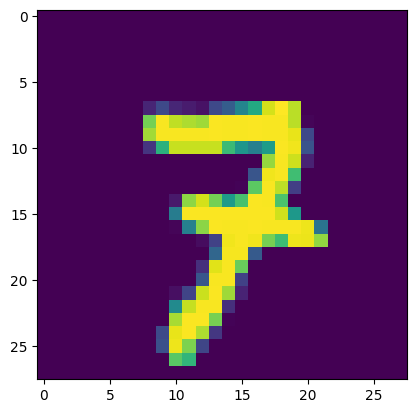

1


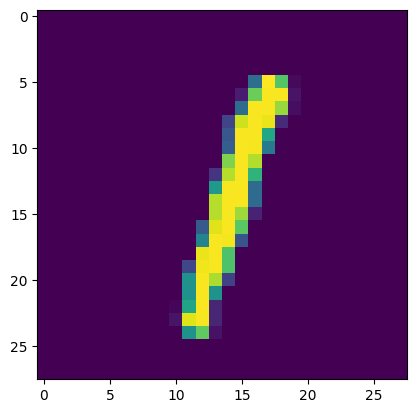

4


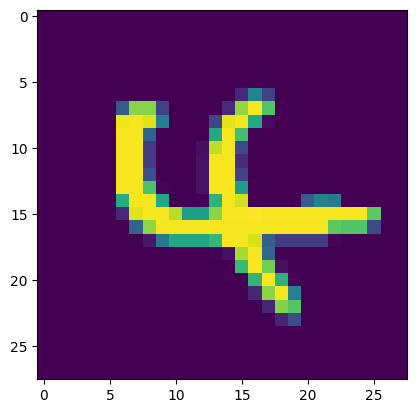

1


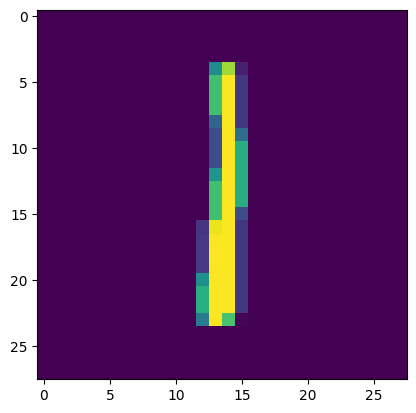

8


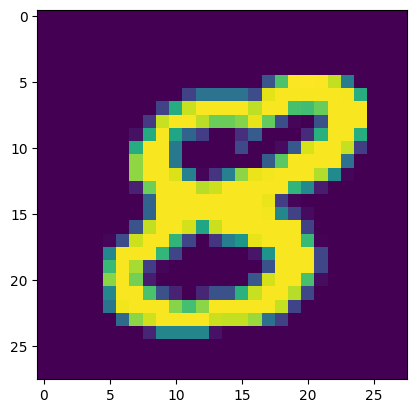

In [6]:
img_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
img_data = torchvision.datasets.MNIST(root="data", train=True, download=False, transform=img_transform)
img_loader = torch.utils.data.DataLoader(img_data, batch_size=32, shuffle=True)

dataiter = iter(img_loader)

batch = next(dataiter)
labels = batch[1][0:5]
images = batch[0][0:5]
for i in range(5):
    print(int(labels[i].detach()))

    image = images[i].numpy()
    plt.imshow(image.T.squeeze().T)
    plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = torch.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = torch.relu(self.fc4(x))
        x = F.dropout(x, training=self.training)
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)
        
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

Save the model to be visualized later in [Netron.app](https://netron.app).

In [8]:
scripted = torch.jit.script(net)
torch.jit.save(scripted, "mnist_network.pt")

In [9]:
optimizer =  optim.SGD(net.parameters(), lr=0.005, momentum=0.7, weight_decay=0.001)
criterion = nn.NLLLoss()

In [10]:
def train_model(num_epochs):
    train_loss_history = list()
    val_loss_history = list()
    patience = 2
    
    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        for batch_id, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            _, pred = torch.max(output.data, 1)
            train_correct += (pred == label).sum().item()
            train_loss += loss.item()
        print(f'Epoch {0 if epoch < 10 else ''}{epoch}: [{100. * train_correct / len(train_loader.dataset):.2f}% | ' +
              f'{train_loss / len(train_loader):.4f}] Training')
        train_loss_history.append(train_loss / len(train_loader))
        
        # with torch.no_grad():
        net.eval()
        val_loss = 0
        val_correct = 0
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            
            output = net(data)
            loss = criterion(output, label)
            if epoch == 0:
                low_loss = loss
            if loss < low_loss:
                low_loss = loss
                torch.save(net.state_dict(), './model.pth')
                torch.save(optimizer.state_dict(), './optimizer.pth')
            
            _, pred = torch.max(output.data, 1)
            val_correct += (pred == label).sum().item()
            val_loss += loss.item()
        val_loss_history.append(val_loss / len(val_loader))
        print(f'Epoch {0 if epoch < 10 else ''}{epoch}: [{100. * val_correct / len(val_loader.dataset):.2f}% | ' +
              f'{val_loss / len(val_loader):.4f}] Validation')
        
        if epoch > 2:
            if abs(train_loss_history[-2] - train_loss_history[-1]) < 0.001 or \
                (100. * train_correct / len(train_loader.dataset)) - (100. * val_correct / len(val_loader.dataset)) > 1.5:
                patience -= 1
                if patience == 0:
                    break
    return (train_loss_history, val_loss_history)

In [11]:
def loss_plot(train_loss_history, val_loss_history):
    plt.plot(train_loss_history, label="Training Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.legend()
    plt.show()

In [12]:
def test_model():
    net.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            outputs = net(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy:.2f}%")

In [13]:
train_loss_history, val_loss_history = train_model(20)

Epoch 00: [46.24% | 1.5073] Training
Epoch 00: [86.65% | 0.4894] Validation
Epoch 01: [84.74% | 0.5256] Training
Epoch 01: [93.05% | 0.2524] Validation
Epoch 02: [91.47% | 0.3235] Training
Epoch 02: [95.00% | 0.1788] Validation
Epoch 03: [93.85% | 0.2367] Training
Epoch 03: [95.97% | 0.1474] Validation
Epoch 04: [95.20% | 0.1904] Training
Epoch 04: [96.33% | 0.1340] Validation
Epoch 05: [96.08% | 0.1575] Training
Epoch 05: [96.67% | 0.1215] Validation
Epoch 06: [96.63% | 0.1359] Training
Epoch 06: [97.16% | 0.1186] Validation
Epoch 07: [97.06% | 0.1189] Training
Epoch 07: [97.10% | 0.1111] Validation
Epoch 08: [97.47% | 0.1030] Training
Epoch 08: [97.46% | 0.1063] Validation
Epoch 09: [97.66% | 0.0948] Training
Epoch 09: [97.47% | 0.1034] Validation
Epoch 10: [97.98% | 0.0809] Training
Epoch 10: [97.39% | 0.1081] Validation
Epoch 11: [97.99% | 0.0804] Training
Epoch 11: [97.49% | 0.1027] Validation
Epoch 12: [98.33% | 0.0688] Training
Epoch 12: [97.64% | 0.0998] Validation
Epoch 13: [9

In [14]:
net.load_state_dict(torch.load('./model.pth', weights_only=True))
optimizer.load_state_dict(torch.load('./optimizer.pth', weights_only=True))

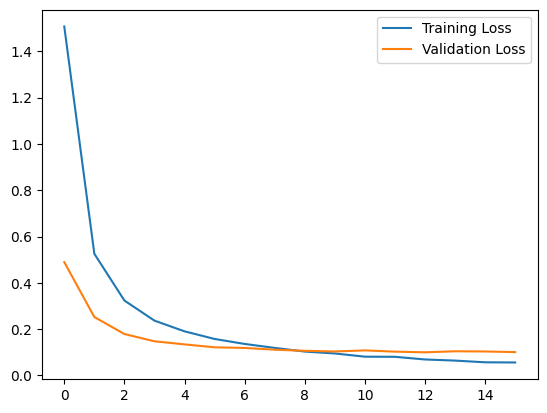

In [15]:
loss_plot(train_loss_history, val_loss_history)

In [16]:
test_model()

Accuracy on the test set: 97.87%
